In [1]:

import pyodbc
import csv
import pandas as pd
print('kör')

dateFilter = "fel.Timestamp >= DATEADD(DAY, -360, GETDATE()) "

db = pyodbc.connect('DRIVER={SQL Server};database=Produktion;server=sed-eu-db-prodrep;uid=analys;pwd=!al2005!')
cursor = db.cursor()

fromString_float = "TraceabilitySystem.dbo.ProductRemarks as fel \
join TraceabilitySystem.dbo.Symptoms as s on                                        s.ID = fel.SymptomID \
join TraceabilitySystem.dbo.States as st on                                        st.ID = fel.ReportStateID \
join TraceabilitySystem.dbo.ProductSerials as p on                           p.ProductID = fel.ProductID \
left join TraceabilitySystem.dbo.Products as pr on                                 pr.id = fel.productid \
left join TraceabilitySystem.dbo.models as m on                                     m.id = pr.modelID \
left join TraceabilitySystem.dbo.RemarkCauseSolutions as atg on             atg.RemarkID = fel.ID \
left join TraceabilitySystem.dbo.ProductSerials as p2 on                    p2.ProductID = atg.oldcomponent \
left join TraceabilitySystem.dbo.Products as pr2 on                               pr2.id = p2.productid \
left join TraceabilitySystem.dbo.Solutions as sol on                              sol.ID = atg.SolutionID \
left join TraceabilitySystem.dbo.Causes as c on                                     c.ID = atg.CauseID " #"\
#join Produktion.dbo.PT_Main as main on                                  main.ProductName = p.Serial collate SQL_Latin1_General_CP1_CI_AS "
#join TraceabilitySystem.dbo.States as st2 on                                      st2.ID = pr.currentStateID \
#left join TraceabilitySystem.dbo.ProductRevisions as r on                    r.ProductID = p2.ProductID \
#left join TraceabilitySystem.dbo.models as m2 on                                   m2.id =  pr2.modelid \
#left join aspnetdb.dbo.aspnet_Users as u1 on                                   u1.UserId = atg.TroubleshooterID \
#join aspnetdb.dbo.aspnet_Users as u2 on                                        u2.UserId = fel.ReporterID \
#left join TraceabilitySystem.dbo.modelgroups as mg on                              mg.id = m.modelgroupid \

#SQL input parametrar
fieldsToSelect = """p.Serial [Unit], st.name as [st], fel.Timestamp [ErrorDate], s.symptom [Symptom], fel.Comment [SymptomComment], 
st.name as [ErrorState], u2.UserName as [Reporter],sol.Solution, p2.serial [ChangedSerial], m2.name [ChangedModel], 
atg.Solutioncomment, atg.timestamp [SolutionDate],
U1.UserName [Troubleshooter], atg.causecomment [CauseComment], c.cause [Cause], m.name [Model], pr.createdtimestamp [UnitCreated]"""
  
#######################################################
fråga="fel.Timestamp [ErrorDate], p.Serial as [Unit], st.name as [st],  s.symptom [Test], fel.Comment [SymptomComment], \
atg.Solutioncomment as [atgSolution], \
atg.causecomment as [CauseComment], c.cause as [Cause], sol.Solution as [Solution] "
#####################################################
sqlQuery = "select " +fråga+ " from " +fromString_float+ " where m.name ='SX10' and " +dateFilter+ " \
order by fel.Timestamp "  

cursor1 = db.execute(sqlQuery)
rows = cursor1.fetchall()

db.commit()
db.close()

remarks = pd.DataFrame(columns=["ErrorDate","Unit","Test"]) 
remarks["ErrorDate"] = [i[0] for i in rows]
remarks["Unit"]      = [i[1] for i in rows]
remarks['Cause']   = [i[7] for i in rows]
remarks["Test"]      = [i[3] for i in rows]
remarks["Fel"]       = [i[4] for i in rows]
remarks["atgSolution"]   = [i[5] for i in rows]
remarks["solutioncomment"]   = [i[6] for i in rows]
remarks["Solution"]   = [i[8] for i in rows]
#remarks["TTS-fel"]  = [i[4] for i in rows]
print('klart')

remarks=remarks.drop_duplicates(['ErrorDate','Unit'], keep='last')
remarks=remarks.reset_index(drop=True)

remarks.to_csv('C:/junk/remarks12mnd.csv' )
remarks.head(3)
#remarks.dtypes

kör
klart


,ErrorDate,Unit,Test,Cause,Fel,atgSolution,solutioncomment,Solution
0,2018-12-07 09:26:23.897,58002032 02865,Tracker Center Point Calibration (Sally Final ...,Konstruktion,"Part test ""Tracker Center Point Calibration"" f...",Provade att köra tracker check. Receiver Align...,,Trackermottagare - omtrim
1,2018-12-07 09:38:31.143,58002032 02654,Tilt Offset Calibration (Sally Final RT2 Calib),Operatörsfel,"Judge of check fails, check ""Tilt Offset Calib...",Får gå genom dom stationer som aldrig körts.,"Tilt, Rotation, Deflection kallibreringar aldr...",Omtestad
2,2018-12-07 09:48:42.953,58002032 02465,Deflection Prism Calibration (Sally Deflection...,Konstruktion,"Part test ""Deflection Prism Calibration"" faile...",,Wait for event failed,HZ - rengöring


In [134]:
#försöker att kategoriesera felfall mha en csv-fil
import pandas as pd
remarks=pd.read_csv('C:/junk/remarks12mnd.csv', encoding='utf-8' )
remarks['felfall']='okänd'
felkod=pd.read_csv('C:/Sally presentationer/felkoder15.csv', sep=',', encoding='ISO-8859-1',quotechar='"' )
#felkod['Fel'].fillna('manuell', inplace=True)
sistaremarks=len(remarks)
sistafelkod=len(felkod)
print(sistafelkod)
remarknr=0
#sätter huvudgrupp
while remarknr<sistaremarks:
    TTS=remarks.iloc[remarknr,5];
    felnr=0
    if (isinstance(TTS, str)):
        while felnr<sistafelkod:
            long=felkod.iloc[felnr,0]   
            #print('felnr',felnr,'\t long=',long,'\t TTS=',TTS)
            if long in TTS:
                remarks.iloc[remarknr,9]=felkod.iloc[felnr,2]
                #print('ny felkod',felkod.iloc[felnr,1]) 
            felnr+=1
    remarknr+=1  
#sätter mindre grupp
remarks['detaljerad']='okänd'
remarknr=0
while remarknr<sistaremarks:
    TTS=remarks.iloc[remarknr,5];
    felnr=0
    if (isinstance(TTS, str)):
        while felnr<sistafelkod:
            long=felkod.iloc[felnr,0]   
            if long in TTS:
                remarks.iloc[remarknr,10]=felkod.iloc[felnr,1]
            felnr+=1
    remarknr+=1      
    
    
remarks.to_csv('C:/junk/felfall12mnd.csv' )
#remarks.iloc[156:173,:]
remarks.iloc[156:158,:]

173


,Unnamed: 0,ErrorDate,Unit,Test,Cause,Fel,atgSolution,solutioncomment,Solution,felfall,detaljerad
156,156,2018-12-12 16:01:50.957,58002032 02557,Scan Accuracy (Sally Final RT1 Test),Konstruktion,"Part test ""Scan Accuracy"" failed.\r\nDetailed ...",Felmeddelandet brukar vara kopplat till en otr...,NaN,Refpuls - omtrim,scanning,scanning
157,157,2018-12-12 16:11:13.563,58002032 02444,Plummet Camera Rotation Parameter Check (Sally...,Konstruktion,"Judge of check fails, check ""Plummet Camera Ro...",Kör om Plummet Camera calib.,NaN,Omtrim,plummet,plummet


In [146]:
import pandas as pd
minafelfall=pd.read_csv('C:/junk/felfall12mnd.csv' )

#minafelfall.head(25)
minafelfall=minafelfall.groupby(["felfall","detaljerad","ErrorDate"],as_index=False).sum()
minafelfall['år'] = pd.DatetimeIndex(minafelfall['ErrorDate']).year
minafelfall['veckonummer'] = pd.to_datetime(minafelfall['ErrorDate'], errors='coerce').dt.week
minafelfall['månad'] = pd.DatetimeIndex(minafelfall['ErrorDate']).month
minafelfall['år-månad'] = pd.to_datetime(minafelfall['ErrorDate']).dt.to_period('M')
minafelfall.head()
minafelfall=minafelfall.drop(minafelfall.columns[4],axis=1)
minafelfall=minafelfall.drop(minafelfall.columns[3],axis=1)
minafelfall=minafelfall.drop(minafelfall.columns[2],axis=1)
minafelfall.to_csv('C:/junk' + '/felmedveckonummer12mnd.csv' )
minafelfall.head()

,felfall,detaljerad,år,veckonummer,månad,år-månad
0,1-wire,1-wire,2018,49,12,2018-12
1,1-wire,1-wire,2018,49,12,2018-12
2,1-wire,1-wire,2018,49,12,2018-12
3,1-wire,1-wire,2018,50,12,2018-12
4,1-wire,1-wire,2018,50,12,2018-12


In [147]:
#vill ha med noll
minafelfall=pd.read_csv('C:/junk/felmedveckonummer12mnd.csv' )
NYDF=minafelfall.pivot_table(index='veckonummer', 
                     columns=['felfall','detaljerad'],
                     
                     fill_value=0, 
                     aggfunc='count').unstack().to_frame('Antal').reset_index().rename(columns={0:'Action'})
#idx=pd.date
NYDF=NYDF.drop(NYDF.columns[0],axis=1)
NYDF.to_csv('C:/junk' + '/felpervecka12mnd.csv' )
NYDF.iloc[2370:2371,:]
#NYDF.tail()

,felfall,detaljerad,veckonummer,Antal
2370,RefPuls,RefPuls,19,15


In [138]:
#antal levererade senaste året

db = pyodbc.connect('DRIVER={SQL Server};database=Produktion;server=sed-eu-db-prodrep;uid=analys;pwd=!al2005!')
cursor = db.cursor()

sqlQuery = "select (p.serial ) as [lag], MIN(t2.Timestamp) as [Slutdatum] \
from TraceabilitySystem.dbo.Products as pr \
join TraceabilitySystem.dbo.ProductSerials as p on pr.ID = p.ProductID \
join TraceabilitySystem.dbo.Models as m on m.ID = pr.modelID \
join TraceabilitySystem.dbo.ModelGroups as mg on m.ModelGroupID = mg.ID \
join TraceabilitySystem.dbo.Timings as t2 on t2.ProductID = p.ProductID \
join TraceabilitySystem.dbo.States as s2 on s2.ID = t2.StateID \
join TraceabilitySystem.dbo.StatesInWorkflows as w2 on s2.ID = w2.StateID \
join TraceabilitySystem.dbo.WorkFlows as wf on wf.ID = w2.ID and wf.ID = m.WorkFlowID \
where w2.ReportTag like 'End Prod' and mg.name = 'Scanning total station' \
group by p.serial \
having min(t2.Timestamp) >=DATEADD(DAY, -360, GETDATE()) "  

cursor1 = db.execute(sqlQuery)
rows = cursor1.fetchall()

db.commit()
db.close()

lev = pd.DataFrame(columns=[]) 
lev["ID"]            = [i[0] for i in rows]
lev["LevDatum"]      = [i[1] for i in rows]
lev['count']         =1
lev['år'] = pd.DatetimeIndex(lev['LevDatum']).year
lev['veckonummer'] = pd.to_datetime(lev['LevDatum'], errors='coerce').dt.week
lev['week'] = np.where(lev['veckonummer'] < 10, \
                      (lev['år'].astype(str).str[2:]+'-0'+lev['veckonummer'].astype(str)),\
                      lev['år'].astype(str).str[2:]+'-'+lev['veckonummer'].astype(str))
lev.to_csv('C:/Sally felsokning/lev.csv' )
Levererade=lev.pivot_table(index='week', 
                     #columns=['week'],
                     
                     fill_value=0, 
                     aggfunc='count').unstack().to_frame('Antal').reset_index().rename(columns={0:'Action'})
Levererade.head(3)
#blir lätt stora hopp när utleveranser varierar, lägger in ett rolling average
Lev['Mean'] = Lev['count'].rolling(window=5).mean().shift(-2)#.iloc[2:].values
Lev['Mean']=Lev['Mean'].ffill(axis=0)
Lev['Mean']=Lev['Mean'].bfill(axis=0)
#Lev=lev.groupby(["week"],as_index=False)['count'].sum()
#Lev['veckonummer']=Lev['week'].astype(str).str[3:]
Lev.to_csv('C:/Sally felsokning/Lev2.csv' )
Lev.head(5)

,Unnamed: 0,week,count,veckonummer,Mean
0,0,18-50,35,50,30.4
1,1,18-51,26,51,30.4
2,2,19-02,30,2,30.4
3,3,19-03,30,3,28.2
4,4,19-04,31,4,31.0


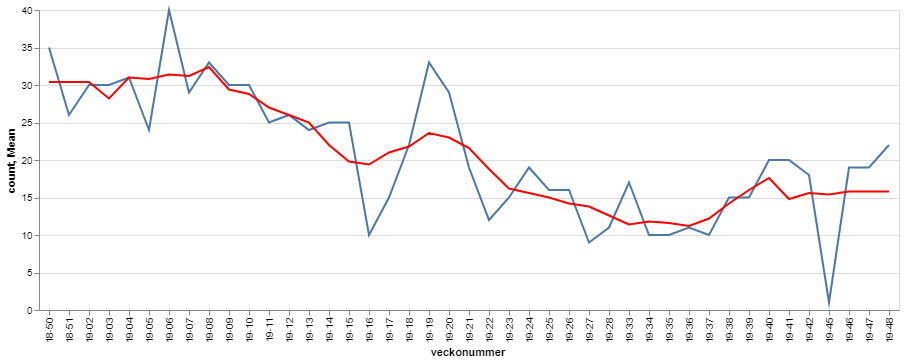

In [127]:
Lev=pd.read_csv('C:/Sally felsokning/Lev2.csv' )

count=alt.Chart(Lev).mark_line().encode(
    alt.X('week', axis=alt.Axis(title='veckonummer ')),
    alt.Y('count:Q' ))
Mean=alt.Chart(Lev).mark_line(color='red').encode(
    alt.X('week', axis=alt.Axis(title='veckonummer ')),
    alt.Y('Mean:Q' ))
count+Mean

In [151]:
#normera antal fel mot leveranser
Leveranser=pd.read_csv('C:/Sally felsokning/Lev2.csv')
Leveranser.head()
NYDF=pd.read_csv('C:/junk' + '/felpervecka12mnd.csv' )
DF=pd.merge(NYDF,Leveranser,
           on=['veckonummer'], how='outer')

DF=DF.drop(DF.columns[0],axis=1)
DF['Antal']=DF['Antal'].fillna(0)
DF['felfrekvens']=(DF['Antal']/DF['Mean']).fillna(0)
DF=DF.drop(['veckonummer','Unnamed: 0_y','Unnamed: 0.1'], axis=1)
DF.to_csv('C:/junk' + '/felfrekvens12mnd.csv' )
DF.tail(4) 
DF.iloc[2765:2769,:]


,felfall,detaljerad,Antal,week,count,Mean,felfrekvens
2765,tele,tele motor,0,19-18,22.0,21.8,0.0
2766,tele,tele rotation,0,19-18,22.0,21.8,0.0
2767,tilt,tilt,0,19-18,22.0,21.8,0.0
2768,utrustning,utrustning,0,19-18,22.0,21.8,0.0


In [152]:
#vill inte rita upp alla som inte är klassade, tar bort rader med felfall=okänd
DF.drop( DF[ DF['felfall'] == 'okänd' ].index , inplace=True)
DF=DF.dropna()
#DF=DF.drop_duplicates(subset=['felfall','veckonummer'])
DF.to_csv('C:/junk' + '/felfrekvens12mnd.csv' )

DF.tail(2) 

,felfall,detaljerad,Antal,week,count,Mean,felfrekvens
7486,tilt,tilt,1,18-51,26.0,30.4,0.032895
7487,utrustning,utrustning,0,18-51,26.0,30.4,0.000000


In [153]:
import pandas as pd
import numpy as np
df=pd.read_csv('C:/junk' + '/felfrekvens12mnd.csv' )

df.to_csv('C:/junk' + '/felfrekvens12mnd_week.csv' )
df.dtypes
df.head(2)

,Unnamed: 0,felfall,detaljerad,Antal,week,count,Mean,felfrekvens
0,156,1-wire,1-wire,1,19-02,30.0,30.4,0.032895
1,157,Avståndsfel,Avståndsfel,2,19-02,30.0,30.4,0.065789


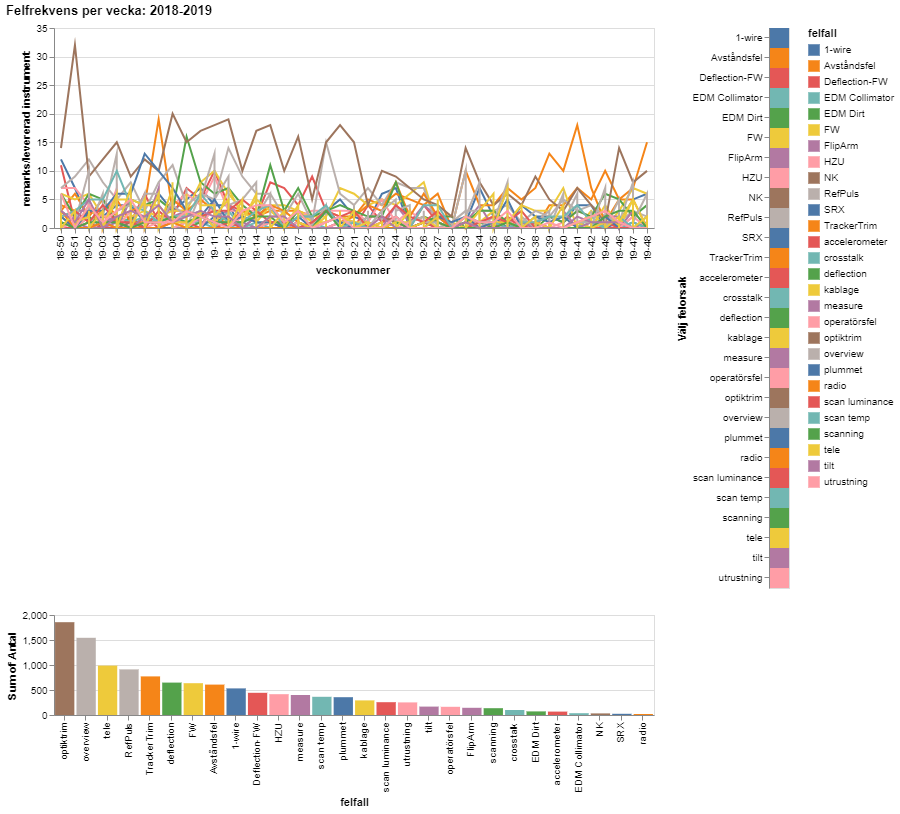

In [154]:
import altair as alt 
from vega_datasets import data
data=pd.read_csv('C:/junk' + '/felfrekvens12mnd.csv', encoding='utf-8' )

color = alt.Color('felfall:N')

# We create two selections:
# - a brush that is active on the top panel
# - a multi-click that is active on the bottom panel
brush = alt.selection_interval(encodings=['x'])
click = alt.selection_multi(encodings=['color'])

# Top panel is scatter plot of temperature vs time
points = alt.Chart().mark_line().encode(
    alt.X('week', axis=alt.Axis(title='veckonummer ')),
    alt.Y('Antal:Q',
        axis=alt.Axis(title='remarks/levererad instrument'),
    ),
    color=alt.condition(brush, color, alt.value('lightgray')),
    tooltip=['felfall', 'felfrekvens','week','Antal'],
).properties(
    width=600,
    height=200
).add_selection(
    brush
).transform_filter(
    click
)

# Bottom panel is a bar chart of species
bars = alt.Chart().mark_bar().encode(
    alt.Y('sum(Antal):Q', scale=alt.Scale(type='linear')),
     
    alt.X('felfall:N', sort=alt.EncodingSortField(field='Antal', 
             op='sum', order='descending')),
    color=alt.condition(click, color, alt.value('lightgray')),
    tooltip=['felfall','sum(Antal)','average(felfrekvens)'],
).transform_filter(
    brush
).properties(
    width=600,height=100,
).add_selection(
    click
)

legend = alt.Chart().mark_rect().encode(
    y=alt.Y('felfall:O', axis=alt.Axis(title='Välj felorsak')),
    color=alt.condition(click, 'felfall:O', 
                        alt.value('lightgray'), legend=None),
    size=alt.value(250)
).properties(
    selection=click
)    


chart=alt.vconcat(points|legend, alt.hconcat (bars),
    data=data,
    title="Felfrekvens per vecka: 2018-2019"
)
#.save('BinnedRemarksWeek1949.html', webdriver='firefox')

chart

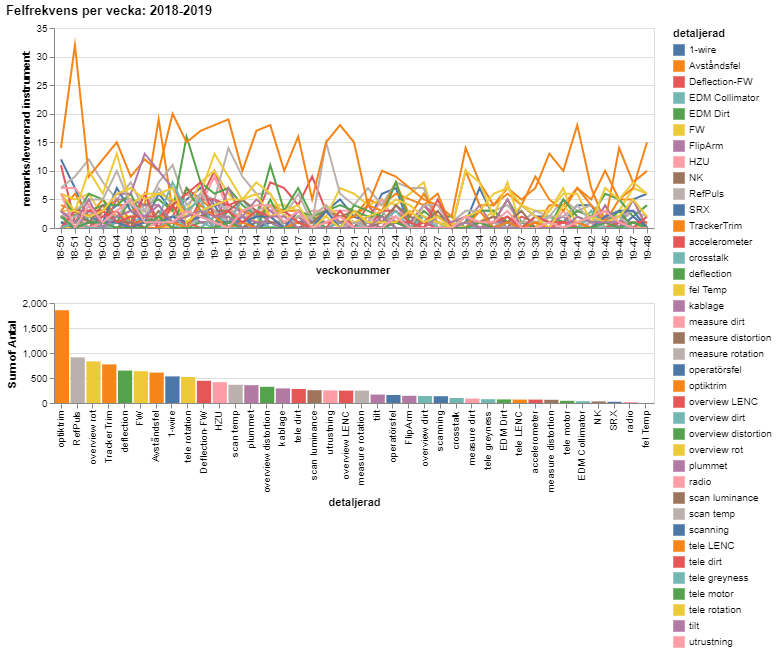

In [156]:
import altair as alt 
from vega_datasets import data
data=pd.read_csv('C:/junk' + '/felfrekvens12mnd.csv', encoding='utf-8' )

#data['felfrekvens']=0.3


color = alt.Color('detaljerad:N')

# We create two selections:
# - a brush that is active on the top panel
# - a multi-click that is active on the bottom panel
brush = alt.selection_interval(encodings=['x'])
click = alt.selection_multi(encodings=['color'])

# Top panel is scatter plot of temperature vs time
points = alt.Chart().mark_line().encode(
    alt.X('week', axis=alt.Axis(title='veckonummer ')),
    alt.Y('Antal:Q',
        axis=alt.Axis(title='remarks/levererad instrument'),
    ),
    color=alt.condition(brush, color, alt.value('lightgray')),
    tooltip=['detaljerad', 'felfrekvens','week','Antal'],
).properties(
    width=600,
    height=200
).add_selection(
    brush
).transform_filter(
    click
)

# Bottom panel is a bar chart of species
bars = alt.Chart().mark_bar().encode(
    alt.Y('sum(Antal):Q', scale=alt.Scale(type='linear')),
    
#    alt.X('felfall:N', sort=alt.EncodingSortField(field='felfall.value_counts(sort=True)', 
#            order='descending', op='count')),
    
    alt.X('detaljerad:N', sort=alt.EncodingSortField(field='Antal', 
             op='sum', order='descending')),
    color=alt.condition(click, color, alt.value('lightgray')),
    tooltip=['detaljerad','sum(Antal)','average(felfrekvens)'],
).transform_filter(
    brush
).properties(
    width=600,height=100,
).add_selection(
    click
)

legend = alt.Chart().mark_rect().encode(
    y=alt.Y('detaljerad:O', axis=alt.Axis(title='Välj felorsak')),
    color=alt.condition(click, 'detaljerad:O', 
                        alt.value('lightgray'), legend=None),
    size=alt.value(250)
).properties(
    selection=click
)    


chart=alt.vconcat(points, alt.hconcat (bars),
    data=data,
    title="Felfrekvens per vecka: 2018-2019"
)
#.save('BinnedRemarksWeek1949.html', webdriver='firefox')

chart

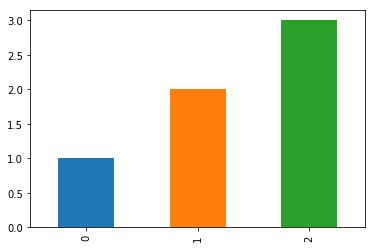